In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord

## Set up sky grid and information ##

In [17]:
nside = 128
# healpix indexes
hpid = np.arange(0, hp.nside2npix(nside))
# Ra/dec in degrees
ra, dec = hp.pix2ang(nside, hpid, lonlat=True)

In [18]:
# Get ecliptic and galactic coordinates
coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
eclip_lat = coord.barycentrictrueecliptic.lat.deg
eclip_lon = coord.barycentrictrueecliptic.lon.deg
gal_lon = coord.galactic.l.deg
gal_lat = coord.galactic.b.deg

In [26]:
# Dustmap from sims_maps  - this is basically just a data directory
def get_dustmap(nside=None):
    if nside is None:
        nside = set_default_nside()
    ebvDataDir = os.getenv('SIMS_MAPS_DIR')
    filename = 'DustMaps/dust_nside_%i.npz' % nside
    dustmap = np.load(os.path.join(ebvDataDir, filename))['ebvMap']
    return dustmap

In [28]:
# Get the dust extinction values at each healpix
dustmap = get_dustmap(nside)

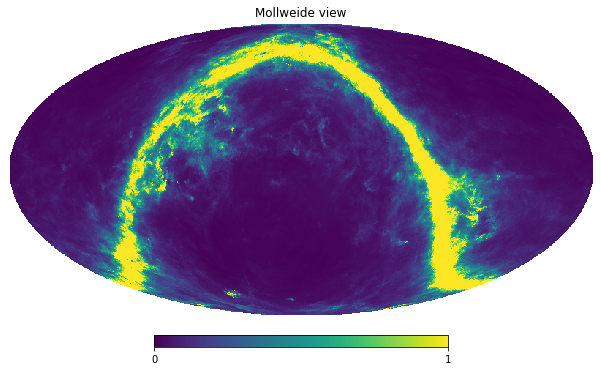

In [33]:
hp.mollview(dustmap, min=0, max=1)

## Estimate of survey time requirements ##

In [117]:
# How much survey time .. approximately .. is it likely to take to cover this area? 
# We can use a rough scaling derived from 
# https://github.com/lsst-pst/survey_strategy/blob/master/fbs_1.7/SurveyFootprints-NvisitsVsArea.ipynb

# x = (scale['NvisitPerPoint*']/825) * (scale['Area']/18000) / (scale['t']/0.76)  == constant (~1)
def scalingfunc(survey_frac=None, nvisits_per_pointing=None, area=None):
    defaults = {'survey_frac': 0.76, 'area': 18000, 'nvisits_per_pointing': 825}
    if area is None:
        area = (survey_frac / defaults['survey_frac']) / (nvisits_per_pointing / defaults['nvisits_per_pointing'])
        return area * defaults['area']
    elif nvisits_per_pointing is None:
        nvisits_per_pointing = (survey_frac / defaults['survey_frac']) / (area / defaults['area'])
        return nvisits_per_pointing * defaults['nvisits_per_pointing']
    elif survey_frac is None:
        survey_frac = nvisits_per_pointing / defaults['nvisits_per_pointing'] * area / defaults['area']
        return survey_frac * defaults['survey_frac']

Text(0, 0.5, 'Survey fraction')

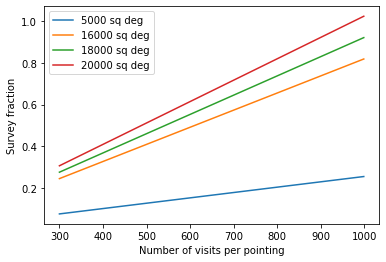

In [123]:
# which leads us to the fraction of a 2x15s 10year survey required 
# from the simulations in the notebook referenced above, I think this is accurate to an order of a % or a few,
# although smaller areas may have more 'edge effects' which would increase their required time 

nvis = np.arange(300, 1000)
for area in (5000, 16000, 18000, 20000):
    plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, area=area), label=f'{area} sq deg')
plt.legend(loc='upper left')
plt.xlabel('Number of visits per pointing')
plt.ylabel('Survey fraction')

## Low-dust extinction extragalactic

In [124]:
# Define extragalactic WFD between -72 and +12.5 with low dust extinction (dust extinction limit = 0.2)
dust_limit = 0.2
dec_max = 12.5
dec_min = -72

exwfd = np.where((dec > dec_min) & (dec < dec_max) & (dustmap < dust_limit), 1, 0)

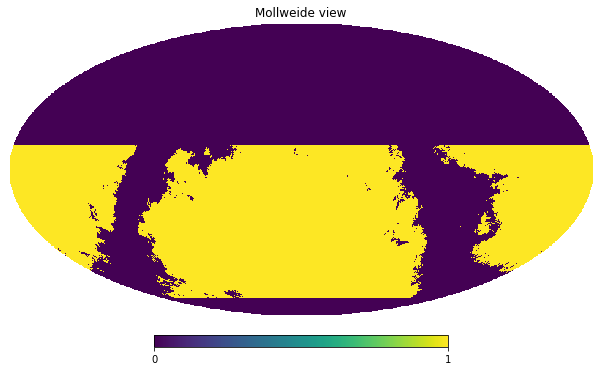

In [126]:
# Where is this on the sky?
hp.mollview(exwfd)

In [127]:
# how much area is covered? 
exgal_area = exwfd.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in extragalactic wfd {exgal_area}')

Area in extragalactic wfd 18283.17276728006


In [168]:
# survey time required?
nvis = 825
t_exgal = scalingfunc(nvisits_per_pointing=nvis, area=exgal_area)
print(f"Survey fraction required for extragalactic WFD, at {nvis} visits per pointing is {t_exgal}")
# But we have a desire to keep the number of visits per pointing higher to keep reserve in 'wfd' labelled area
nvis = int(825 * 1.08)
t_exgal = scalingfunc(nvisits_per_pointing=nvis, area=exgal_area)
print(f"Survey fraction required for extragalactic WFD with {nvis} visits per pointing {t_exgal}")

Survey fraction required for extragalactic WFD, at 825 visits per pointing is 0.7719561835073803
Survey fraction required for extragalactic WFD with 891 visits per pointing 0.8337126781879708


## Galactic Plane ##

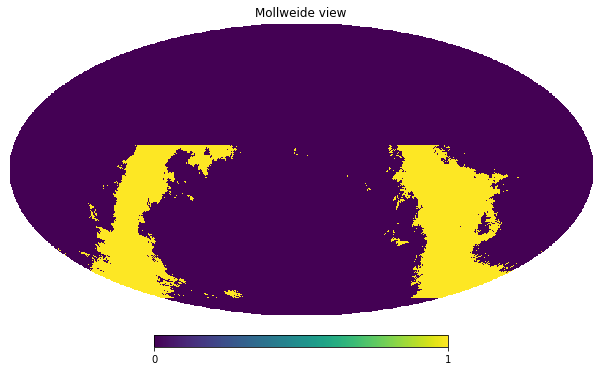

In [170]:
# Start with defining galactic plane zone as the entirety of the plane which was excluded by dust extinction above
galwfd = np.where((dec > dec_min) & (dec < dec_max) & (dustmap > dust_limit), 1, 0)
hp.mollview(galwfd, max=1)

In [171]:
# how much area is covered? 
gp_area = galwfd.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in large galactic wfd {gp_area}')

Area in large galactic wfd 5773.500985407616


In [172]:
# Time required?
nvis = 825
t_gp = scalingfunc(nvisits_per_pointing=nvis, area=gp_area)
print(f"Survey fraction required for galactic WFD, at {nvis} visits per pointing {t_gp}")
nvis = int(825*1.08)
t_gp = scalingfunc(nvisits_per_pointing=nvis, area=gp_area)
print(f"Survey fraction required for galactic WFD with {nvis} visits per pointing {t_gp}")

Survey fraction required for galactic WFD, at 825 visits per pointing 0.24377004160609936
Survey fraction required for galactic WFD with 891 visits per pointing 0.2632716449345873


But the galactic plane has options - one being separating the plane into 'bulge' and 'the rest' or 'bulge', 'bridge' (a region at the opposite RA as the bulge) and 'the rest'.

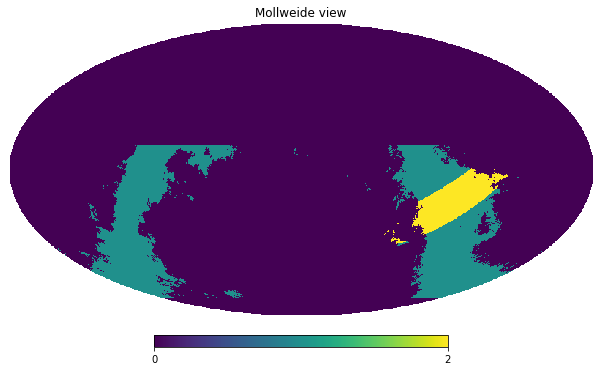

In [176]:
# Or if we reduce the number of visits to 300 over most of the plane and leave the bulge at 825
bulge_lon_span = 20
bulge_lat_span = 10
bulge = np.where(galwfd & 
                 ((gal_lon) < bulge_lon_span) | (gal_lon > (360-bulge_lon_span)) & 
                 (abs(gal_lon) < bulge_lat_span), 1, 0)
gp_nobulge = galwfd - bulge
hp.mollview(bulge * 2 + gp_nobulge, max=2)

In [175]:
bulge_area = bulge.sum() * hp.nside2pixarea(nside, degrees=True)
gp_nobulge_area = gp_nobulge.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in bulge {gp_area} and non-bulge plane {gp_nobulge_area}')
nvis_bulge = 825
nvis_nobulge = 300
t_bulge = scalingfunc(nvisits_per_pointing=nvis_bulge, area=bulge_area)
t_nobulge = scalingfunc(nvisits_per_pointing=nvis_nobulge, area=gp_nobulge_area)
print(f"Survey fraction required to cover the bulge to {nvis_bulge} visits per pointing\n",
      f" and the remainder of the plane to {nvis_nobulge} visits per pointing",
      f"{t_bulge + t_nobulge}")

Area in bulge 5773.500985407616 and non-bulge plane 4925.604580333035
Survey fraction required to cover the bulge to 825 visits per pointing
  and the remainder of the plane to 300 visits per pointing 0.11142551449816124


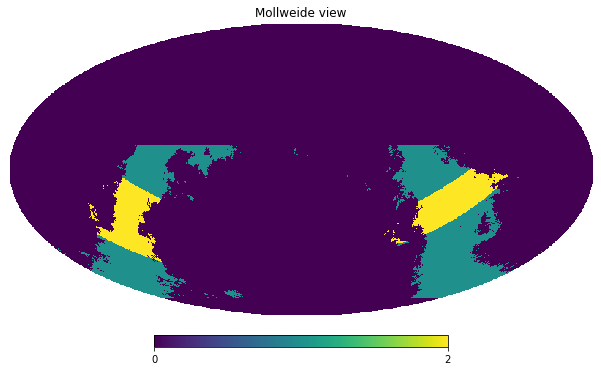

In [178]:
# And similar, but adding additional coverage at the 'bridge'
# Or if we reduce the number of visits to 300 over most of the plane and leave the bulge at 825
outer_bridge_l = 240
outer_bridge_lon_span = 20
outer_bridge_lat_span = 20 
bulge = np.where(galwfd & 
                 ((gal_lon) < bulge_lon_span) | (gal_lon > (360-bulge_lon_span)) & 
                 (abs(gal_lon) < bulge_lat_span), 1, 0)
bridge = np.where(galwfd & 
                  ((gal_lon < (outer_bridge_l + outer_bridge_lon_span))
                    & (gal_lon > (outer_bridge_l-outer_bridge_lon_span))
                    & (np.abs(gal_lat) < outer_bridge_lat_span)), 1, 0)
gp_nobulge = galwfd - bulge - bridge
hp.mollview(bulge*2 + bridge*2 + gp_nobulge, max=2)

In [182]:
bulge_area = bulge.sum() * hp.nside2pixarea(nside, degrees=True)
bridge_area = bridge.sum() * hp.nside2pixarea(nside, degrees=True)
gp_nobulge_area = gp_nobulge.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in bulge {gp_area}, bridge {bridge_area}, and non-bulge plane {gp_nobulge_area}')
nvis_bulge = 825
nvis_bridge = 825
nvis_nobulge = 300
t_bulge = scalingfunc(nvisits_per_pointing=nvis_bulge, area=bulge_area)
t_bridge = scalingfunc(nvisits_per_pointing=nvis_bridge, area=bridge_area)
t_nobulge = scalingfunc(nvisits_per_pointing=nvis_nobulge, area=gp_nobulge_area)
print(f"Survey fraction required to cover the bulge to {nvis_bulge} visits per pointing\n",
      f" the bridge to {nvis_bridge} visits per pointing\n",
      f" and the remainder of the plane to {nvis_nobulge} visits per pointing",
      f"{t_bulge + t_bridge + t_nobulge}")

Area in bulge 5773.500985407616, bridge 753.6856933996278, and non-bulge plane 4171.9188869334075
Survey fraction required to cover the bulge to 825 visits per pointing
  the bridge to 825 visits per pointing
  and the remainder of the plane to 300 visits per pointing 0.131676059391525


In [183]:
t_gal = t_bulge + t_bridge + t_nobulge

## Ecliptic coverage ##

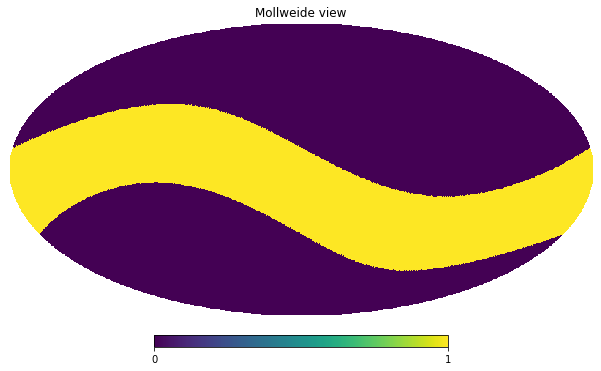

In [134]:
# Ecliptic latitude limits are not symmetric because the northern most point of the ecliptic is +23
eclat_min = -30
eclat_max = 10. 

ecplane = np.where((eclip_lat > eclat_min) & (eclip_lat < eclat_max), 1, 0)

hp.mollview(ecplane, max=1)

In [184]:
# how much area is covered? 
ecplane_area = ecplane.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in ecliptic plane total {ecplane_area}')

nvis=500
t_ecliptic = scalingfunc(nvisits_per_pointing=nvis, area=ecplane_area)
print(f"Survey fraction required for ecliptic plane, at {nvis} visits per pointing {t_ecliptic}")

Area in ecliptic plane total 13897.0241774065
Survey fraction required for ecliptic plane, at 500 visits per pointing 0.3556140866945771


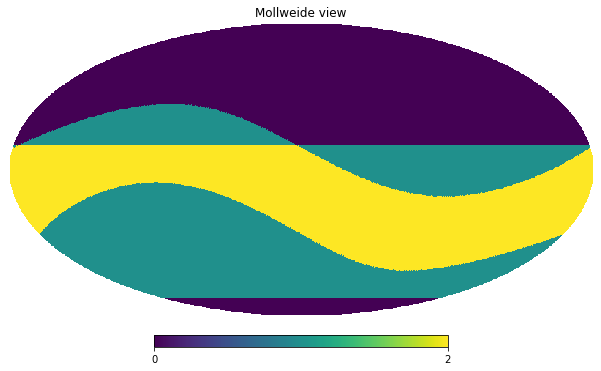

In [185]:
# But obviously some of this overlaps the remainder of the survey (although there may be different requirements)
hp.mollview(exwfd + galwfd + ecplane, max=2)

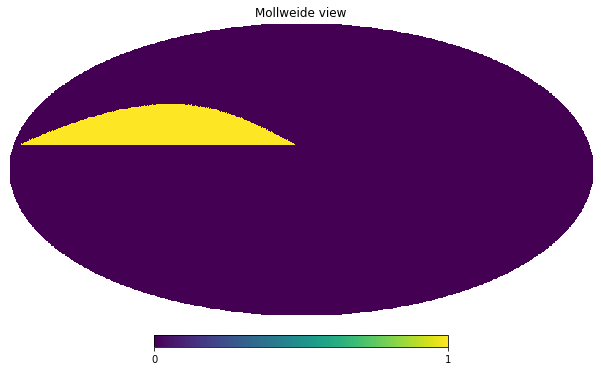

In [186]:
# So let's look at just the northern ecliptic spur part - where it's not potentially covered by other survey visits
nes = np.where((eclip_lat > eclat_min) & (eclip_lat < eclat_max) & (dec > dec_max), 1, 0)
hp.mollview(nes)

In [188]:
# how much area is covered? 
nes_area = nes.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in ecliptic plane total {nes_area}')

nvis=500
t_nes = scalingfunc(nvisits_per_pointing=nvis, area=nes_area)
print(f"Survey fraction required for ecliptic plane, at {nvis} visits per pointing {t_nes}")

Area in ecliptic plane total 2210.279814663608
Survey fraction required for ecliptic plane, at 500 visits per pointing 0.05655934879273879


## Magellanic Clouds ##

In [189]:
import numbers
def _angularSeparation(long1, lat1, long2, lat2):
    """
    Angular separation between two points in radians
    Parameters
    ----------
    long1 is the first longitudinal coordinate in radians
    lat1 is the first latitudinal coordinate in radians
    long2 is the second longitudinal coordinate in radians
    lat2 is the second latitudinal coordinate in radians
    Returns
    -------
    The angular separation between the two points in radians
    Calculated based on the haversine formula
    From http://en.wikipedia.org/wiki/Haversine_formula
    """
    t1 = np.sin(lat2/2.0 - lat1/2.0)**2
    t2 = np.cos(lat1)*np.cos(lat2)*np.sin(long2/2.0 - long1/2.0)**2
    _sum = t1 + t2

    if isinstance(_sum, numbers.Number):
        if _sum<0.0:
            _sum = 0.0
    else:
        _sum = np.where(_sum<0.0, 0.0, _sum)

    return 2.0*np.arcsin(np.sqrt(_sum))

In [190]:
def magellanic_clouds_healpixels(nside, lmc_radius=10, smc_radius=5):
    """
    Define the Magellanic clouds region. Return a healpix map with cloud pixels as 1.
    """
    # healpix indexes
    hpid = np.arange(0, hp.nside2npix(nside))
    # Ra/dec in degrees
    ra, dec = hp.pix2ang(nside, hpid, lonlat=True)
    ra = np.radians(ra)
    dec = np.radians(dec)
    result = np.zeros(hp.nside2npix(nside))

    lmc_ra = np.radians(80.893860)
    lmc_dec = np.radians(-69.756126)
    lmc_radius = np.radians(lmc_radius)

    smc_ra = np.radians(13.186588)
    smc_dec = np.radians(-72.828599)
    smc_radius = np.radians(smc_radius)

    dist_to_lmc = _angularSeparation(lmc_ra, lmc_dec, ra, dec)
    lmc_pix = np.where(dist_to_lmc < lmc_radius)
    result[lmc_pix] = 1

    dist_to_smc = _angularSeparation(smc_ra, smc_dec, ra, dec)
    smc_pix = np.where(dist_to_smc < smc_radius)
    result[smc_pix] = 1
    return result

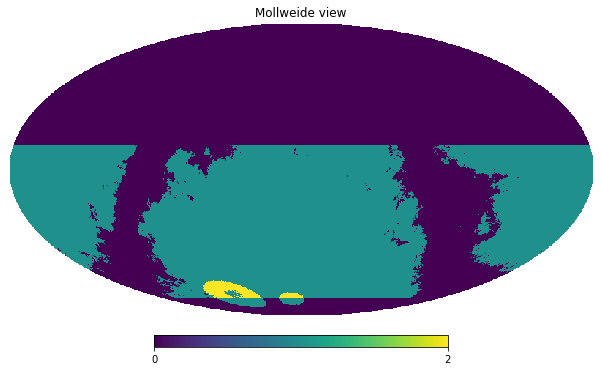

In [194]:
# So this shows us the magellanic clouds, but they do overlap with WFD (visit requirements may not be the same)
mag_clouds = magellanic_clouds_healpixels(nside)
hp.mollview(mag_clouds + exwfd, max=2)

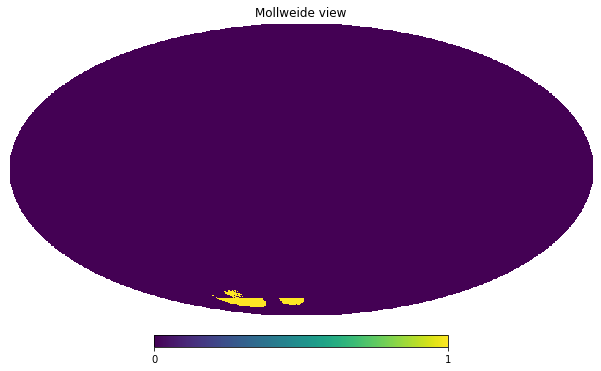

In [202]:
# If we want to just include the area outside the extraglactic WFD
mag_clouds = np.where((mag_clouds==1) & (exwfd==0), 1, 0)
hp.mollview(mag_clouds, max=1)

In [203]:
# how much area is covered? 
mag_area = mag_clouds.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in magellanic clouds total {mag_area}')

nvis=825
t_mag = scalingfunc(nvisits_per_pointing=nvis, area=mag_area)
print(f"Survey fraction required for magellanic clouds, at {nvis} visits per pointing {t_mag}")

Area in magellanic clouds total 171.6355504456836
Survey fraction required for magellanic clouds, at 825 visits per pointing 0.007246834352151085


## Total ##

In [205]:
t_total = t_exgal + t_gal + t_nes + t_mag
# We need at least 5% of the time for DDFs 
t_ddf = .05
# We need to reserve a few percent for mini-minisurveys (ToO? twilight NEO? DCR?)
t_mini = .03
t_total += t_ddf + t_mini
print(f"Total time required (out of 1) {t_total}")

Total time required (out of 1) 1.1091949207243856
